In [76]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
    
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
import easing
from collections import Counter
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

sys.path.append('../Utility_Scripts/')
from synthetic_data_generator import MLR,meal_income
from ensemble_methods import EnsembleModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# load ML packages

from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,StratifiedKFold,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
from matplotlib.patches import Rectangle as rec
from easing import easing



# Introduction


![fig](../media/open_figure_new.png)


In [19]:
# Core helper Functions

In [20]:
class Linear_Uncertainty_Predictor():
    def __init__(self,X_data,y_data):
        self.X_train =X_data
        self.y_train = y_data
        
    def train_models(self,n_splits=5,kernal='linear'):
        '''Function for training models 
        Inputs:
        X_dataset: Inputs of the training data (MxN)
        y_dataset: Outputs of the trainig data (1xN)
        params: the parameters of the LGBM model
        n_split: the number of splits to be used to creat int(n_splits) seperate models

        Returns:
        models: int(n_splits) number of independent models trained on the folds of the data
        '''

        ss = ShuffleSplit(test_size=1/n_splits,n_splits=n_splits,random_state=42)

        models=[]
        coeffs=[]
        for train_index, test_index in ss.split(self.X_train):
            X_train, X_val =self.X_train[train_index,:], self.X_train[test_index,:], 
            y_train, y_val =self.y_train[train_index], self.y_train[test_index]
            reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
            
            models.append(reg)
            coeffs.append(reg.coef_[0][0])
        self.models=models
        self.coefficients=coeffs
        
    def predict(self,X):
        predictions=[]
        for model in self.models:
            predictions.append(model.predict(X))
        
        # Values chosen by median committe
        ensemble_predictions =np.mean(np.stack(predictions, axis=0) ,axis=0)
        ensemble_uncertainty=np.std(np.stack(predictions, axis=0) ,axis=0)
        self.predictions={'prediction':ensemble_predictions,'uncertainty':ensemble_uncertainty}
        self.raw_predictions={'X':np.squeeze(np.stack(predictions, axis=0))}
        
        return self.predictions
    

# First example : Individual income vs expendeture on meals

Hypothetically, We asked 1000 people what they spent on their last meal and how much money they make per year.

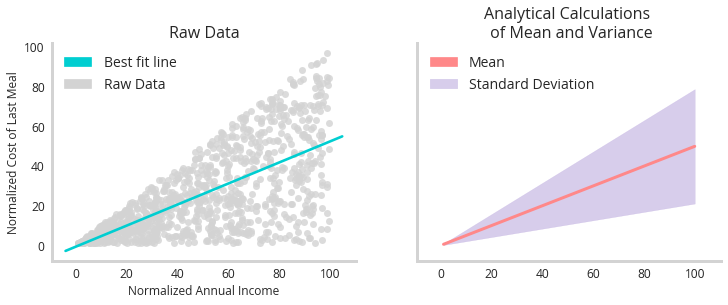

In [21]:
meal_income_dict=meal_income(size=1000)
x_values=meal_income_dict['X']
y_values=meal_income_dict['y']
fig,ax=plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
sns.regplot(x_values.ravel(),y_values.ravel(),ax=ax[0],scatter_kws={'color':'#d3d3d3'},ci=None)


ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Normalized Cost of Last Meal')
ax[0].set_title('Raw Data')
ax[1].set_title('Analytical Calculations \n of Mean and Variance')

mu=meal_income_dict['mu']
sigma=meal_income_dict['sigma']

ax[1].plot(x_values.ravel(), mu,linewidth=3,color='#FF8889')
ax[1].fill_between(x_values.ravel(), mu - sigma, mu + sigma, alpha=0.5,color='#b19cd9')

### adding custom legends
texts = ["Best fit line", "Raw Data"]
colors= ['darkturquoise','#d3d3d3']
recs=[rec((0,0),1,1,fc=color) for color in colors]
ax[0].legend(recs,texts)


texts = ["Mean", "Standard Deviation"]
colors= ['#FF8889','#b19cd9']
alphas=[1,0.5]
recs=[rec((0,0),1,1,fc=color,alpha=alphas[j]) for j,color in enumerate(colors)]
ax[1].legend(recs,texts,loc='upper left')
fig.savefig('figures/meal_expenses.png',bbox_inches='tight')

# Example Ensemble Method 5 fold split : Linear Model

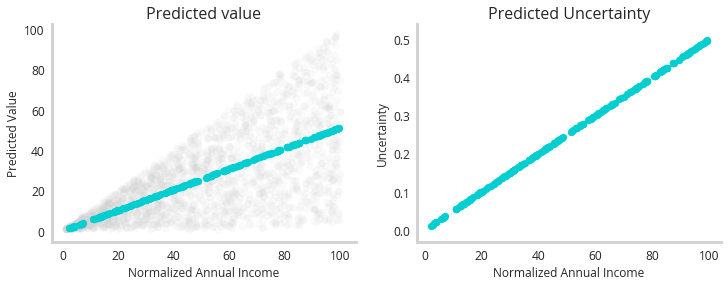

In [72]:
X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(x_values, y_values, test_size=0.1,random_state=42)
Predictor=Linear_Uncertainty_Predictor(X_dataset,y_dataset)
Predictor.train_models(n_splits=5)

prediction_dict=Predictor.predict(X_holdout)


fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(x_values.ravel(),y_values.ravel(),color='#d3d3d3',alpha=0.1)

ax[0].scatter(X_holdout,prediction_dict['prediction'])
# ax[0].plot([0,100],[0,100],color='#d3d3d3')
#ax[1].set_ylim([0,0.05])
# ax[0].fill_between(x_values.ravel(), mu - sigma, mu + sigma, alpha=0.5,color='#d3d3d3')

ax[1].scatter(X_holdout,prediction_dict['uncertainty'])
ax[1].set_xlabel('Normalized Annual Income')
ax[1].set_ylabel('Uncertainty')
ax[1].set_title('Predicted Uncertainty')
ax[0].set_title('Predicted value')

ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Predicted Value')
fig.savefig('figures/linear_model_summary.png',dpi=300,bbox_inches='tight')

# Examples: Large Ensembles with LGBM

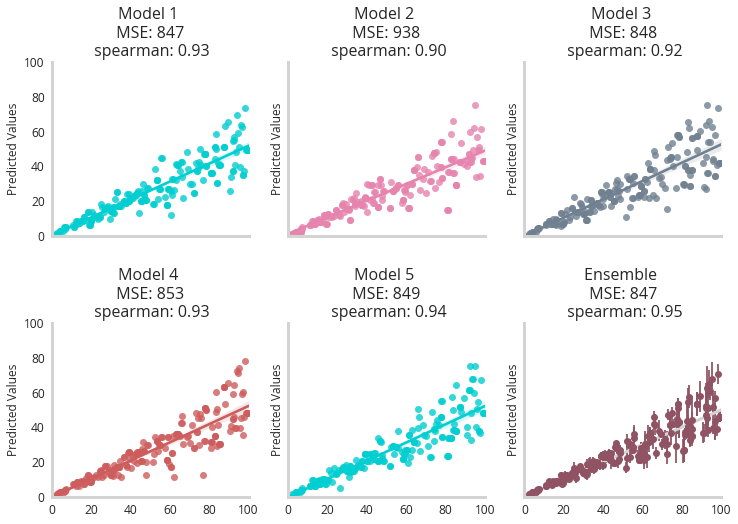

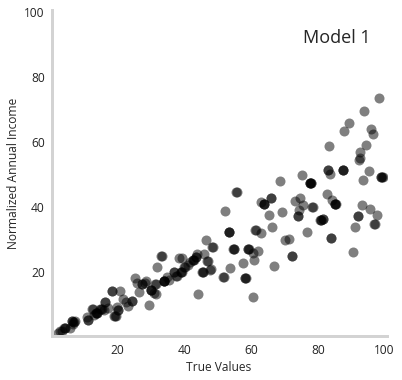

In [92]:
X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(x_values, y_values, test_size=0.1,random_state=42)

LGBM_model=EnsembleModel(X_dataset,y_dataset)
LGBM_model.train_models(n_splits=5,kernal='LGB')
LGBM_model.predict(X_holdout)
LGBM_model.visualize_ensemble(X_holdout,destination='figures')




In [90]:
import os
from os.path import app

SyntaxError: invalid syntax (<ipython-input-90-127831c4f43c>, line 2)

# Testing Ensemble Uncertainty Quantification using synthetic data

In order to validate our methods, we're going to 


* Aleatory uncertainty refers to the inherent uncertainty due to the probabilistic variability. This type of uncertainty is Irreducible, in that there will always be variability in the underlying variables.
* A classic example of heteroscedasticity is that of income versus expenditure on meals. As one's income increases, the variability of food consumption will increase. A poorer person will spend a rather constant amount by always eating inexpensive food; a wealthier person may occasionally buy inexpensive food and at other times eat expensive meals. Those with higher incomes display a greater variability of food consumption.


All Coefficients [0.6194086719520138, -1.0590674874833543, 0.766361142771241, 0.628179210362515, -0.6042787371172822, 2.401018941236067, -0.36779401968468695, 1.9695209954469157, 0.9313369330058368, -0.38930278563466914]


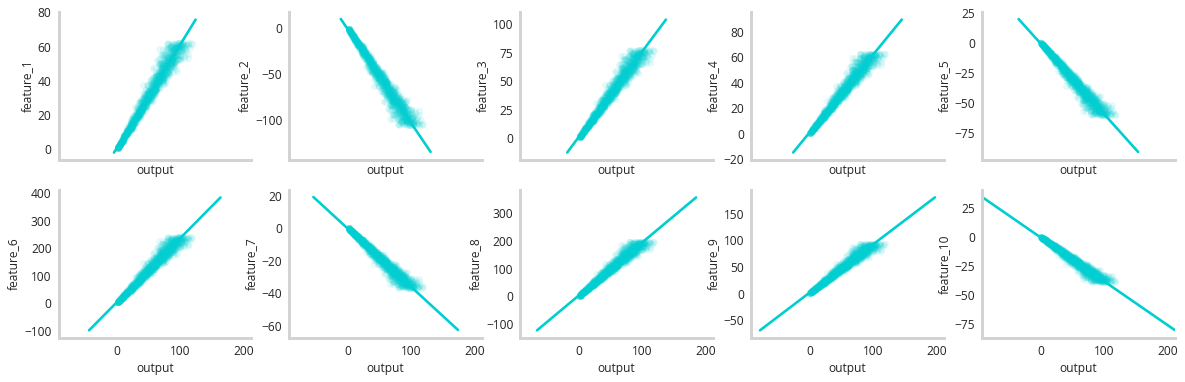

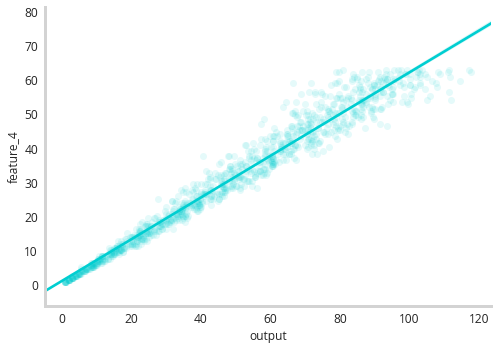

In [33]:
all_data, X,y,ngroups=synthetic_uncertainty_data()
x_features=list(X.columns)
fig,ax=plt.subplots(2,5,figsize=(20,6),sharex=True)
axs=ax.ravel()
for l,x_feature in enumerate(x_features):
    sns.regplot(all_data.output,all_data[x_feature],ax=axs[l],color='darkturquoise',scatter_kws={'alpha':0.1})
    
fig,ax=plt.subplots()

sns.regplot(all_data.output,all_data['feature_4'],ax=ax,color='darkturquoise',scatter_kws={'alpha':0.1})
    

# Load Boston housing dataset 

In [8]:
from sklearn.datasets import load_boston

In [9]:
X, y = load_boston(return_X_y=True)


In [141]:
# create stratified holdout set


def continuous_stratification(y,n_bins,test_size=0.1):
    '''Function that returns the stratified indexes of a continously valued y'''
    bins=np.linspace(min(y), max(y),n_bins)
    digitized_y=np.digitize(y,bins)
    index_list=np.arange(len(y))
    stratified_indexes=[]

    n_samples=int(len(y)*test_size)
    bucket_list=list(set(digitized_y))
    n_samples_per_bucket=int(n_samples/len(bucket_list))

    for bucket in list(set(digitized_y)):
        sub_index_list=index_list[digitized_y==bucket]
        sample_indexes=np.random.choice(sub_index_list,size=n_samples_per_bucket,replace=False)
        stratified_indexes+=list(sample_indexes)
    # returns test and train indexes
    return np.array(stratified_indexes),np.setdiff1d(index_list,stratified_indexes)



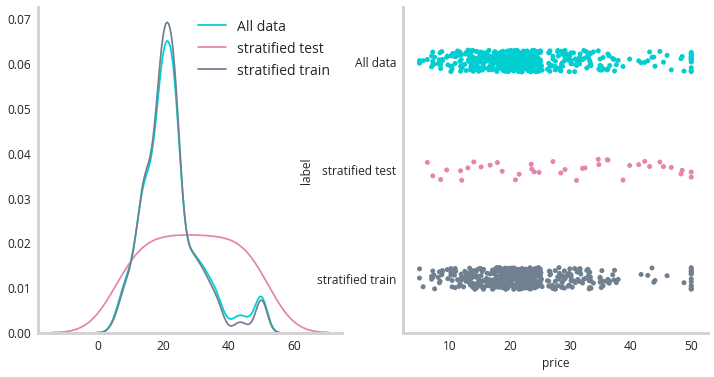

In [149]:
test,train=continuous_stratification(y,20,test_size=.1)
X_dataset,y_dataset=X[train,:],y[train]
X_holdout,y_holdout=X[test,:],y[test]


fig,ax=plt.subplots(1,2,figsize=(12,6))
sns.distplot(y,hist=False,ax=ax[0],label='All data')
sns.distplot(y[test],hist=False,ax=ax[0],label='stratified test')
sns.distplot(y[train],hist=False,ax=ax[0],label='stratified train')


complete=pd.DataFrame({'price':y,'label':'All data'})
test=pd.DataFrame({'price':y[test],'label':'stratified test'})
train=pd.DataFrame({'price':y[train],'label':'stratified train'})
meta_data=pd.concat([complete,test,train])

sns.stripplot(x='price',y='label',data=meta_data,ax=ax[1])



In [41]:
params = {
    'num_leaves': 50,
    'metric': ['l1', 'l2'],
    'verbose': -1,
    'learning_rate': 0.05,
    'lambda_l2': 1,
    'drop_rate': 0.1,
    'seed': 123,
    'objective':'regression'
}
mdl = lgb.LGBMRegressor(params,
            num_boost_round=800,
            )





gridParams = {
    'learning_rate': [ 0.025,0.05,0.1],
    'num_leaves': [25,50,75],
    'n_estimators': [4,8,16,24],
    'boosting_type' : ['gbdt','dart'],
    'objective' : ['regression'],
    'lambda_l2': [0,1,1.2,1.4],
    'lambda_l1': [0,1,1.2,1.4]
    
    
}




grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5,n_jobs=-1,scoring='neg_mean_squared_error')

grid.fit(X, y)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 27.0min finished
The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
Found `num_boost_round` in params. Will use it i

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type={'drop_rate': 0.1,
                                                    'lambda_l2': 1,
                                                    'learning_rate': 0.05,
                                                    'metric': ['l1', 'l2'],
                                                    'num_leaves': 50,
                                                    'objective': 'regression',
                                                    'seed': 123,
                                                    'verbose': -1},
                                     class_weight=None, colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_chil...
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
    

In [1]:
print(grid.best_params_, grid.best_score_)


NameError: name 'grid' is not defined

In [ ]:
#

In [14]:
def train_models(X_dataset,y_dataset,n_splits=5):
    '''Function for training models 
    Inputs:
    X_dataset: Inputs of the training data (MxN)
    y_dataset: Outputs of the trainig data (1xN)
    params: the parameters of the LGBM model
    n_split: the number of splits to be used to creat int(n_splits) seperate models
    
    Returns:
    models: int(n_splits) number of independent models trained on the folds of the data
    '''

    
    kf = KFold(n_splits=n_splits)

    models=[]

    for train_index, test_index in kf.split(X_dataset):
        X_train, X_val, y_train, y_val = X_dataset[train_index,:], X_dataset[test_index,:], y_dataset[train_index], y_dataset[test_index]
        reg = LinearRegression().fit(X_train, y_train)

        models.append(reg)
    return models

class ensemble_model():
    '''This class is '''
    def __init__(self,models):
        self.models=models
        
    def predict(self,X):
        predictions=[]
        for model in self.models:
            predictions.append(model.predict(X))
        
        # Values chosen by median committe
        ensemble_predictions =np.median(np.stack(predictions, axis=0) ,axis=0)
        ensemble_uncertainty=np.std(np.stack(predictions, axis=0) ,axis=0)
        
        return {'prediction':ensemble_predictions,'uncertainty':ensemble_uncertainty}

# Example 

In [15]:
### training individual models and building ensemble model

models=train_models(X_dataset,y_dataset)   
ensemble=ensemble_model(models)



Text(0.5, 1.0, 'Model 5 \n MSE: 37 \n spearman: 0.94')

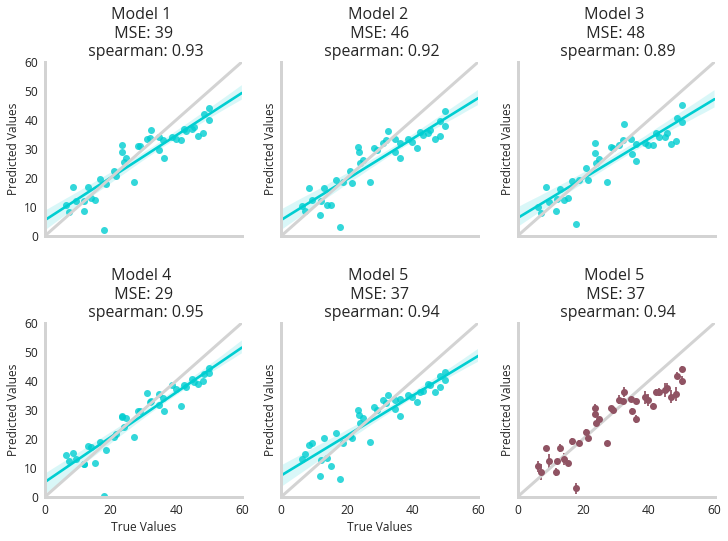

In [160]:
fig,ax=plt.subplots(2,3,figsize=(12,8),sharex=True,sharey=True,gridspec_kw={ 'hspace': 0.5})
ax=ax.ravel()

ax[0].set_xlim([0,60])
ax[0].set_ylim([0,60])

titles=['Model 1','Model 2','Model 3','Model 4','Model 5','Ensemble Model']
colors=['darkturquoise']*5+['#905363']
test_vals=y_holdout
for j,model in enumerate(models):
    predicted_vals=model.predict(X_holdout)
    
    
    
    sns.regplot(test_vals,predicted_vals,ax=ax[j],color=colors[j])
    ax[j].plot([0,100],[0,100],color='#d3d3d3',linewidth=3)
    if j>2:
        ax[j].set_xlabel('True Values')
    ax[j].set_ylabel('Predicted Values')
    ax[j].set_title(f'{titles[j]} \n MSE: {mean_squared_error(test_vals,predicted_vals):.0f} \n spearman: {spearmanr(test_vals,predicted_vals)[0]:.2f}')

ensemble_output=ensemble.predict(X_holdout)
ensemble_predictions=ensemble_output['prediction']
ensemble_uncertainty=ensemble_output['uncertainty']

ax[5].errorbar(test_vals,ensemble_predictions, yerr=ensemble_uncertainty,color='#905363',fmt='o')
ax[5].plot([0,100],[0,100],color='#d3d3d3',linewidth=3)
ax[5].set_ylabel('Predicted Values')
ax[5].set_title(f'{titles[j]} \n MSE: {mean_squared_error(test_vals,predicted_vals):.0f} \n spearman: {spearmanr(test_vals,predicted_vals)[0]:.2f}')


# fig.savefig('figs/committee_models.png',bbox_inches='tight')

In [28]:
correlations={}
for k in range(3,30):
    MSE=[]
    Spearman=[]
    MSE_shuffled=[]
    Spearman_shuffled=[]
    dfs=[]
    for n in tqdm(range(1000)):
        X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(X, y, test_size=0.1)
        test_vals=y_holdout

        models=train_models(X_dataset,y_dataset,n_splits=k)
        committee=ensemble_model(models)

        prediction_dict=committee.predict(X_holdout)
        predicted_vals=prediction_dict['prediction']
        uncertainty_vals=prediction_dict['uncertainty']
        errors=abs(predicted_vals-test_vals)


        dfs.append(pd.DataFrame({'errors':errors,'uncertainty':uncertainty_vals}))

        # True values
        MSE.append(mean_squared_error(test_vals,predicted_vals))
        Spearman.append(spearmanr(test_vals,predicted_vals)[0])

        # following by shuffled values
        np.random.shuffle(test_vals)
        MSE_shuffled.append(mean_squared_error(test_vals,predicted_vals))
        Spearman_shuffled.append(spearmanr(test_vals,predicted_vals)[0])
    error_correlation=pd.concat(dfs)
    correlations[str(k)]=spearmanr(error_correlation.errors,data.uncertainty)[0]
    

In [26]:
correlations

{'3': -0.007601460758197635,
 '4': -0.0008074638901265777,
 '5': 0.006728244293425157,
 '6': -0.003029471911154104,
 '7': 0.0017348674857519222,
 '8': -0.005852868844641174,
 '9': -0.00028883174654341403}

Text(0.5, 1.0, 'Spearmans Correlation \n 0.29')

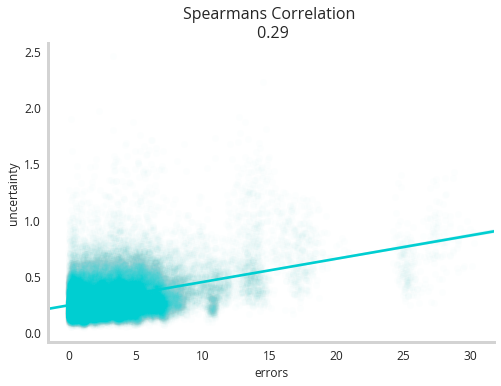

In [23]:
# How many splits should you use?
data=pd.concat(dfs)
sns.regplot(x='errors',y='uncertainty',data=data,scatter_kws={'alpha':0.01})

plt.title(f'Spearmans Correlation \n {spearmanr(data.errors,data.uncertainty)[0]:.2f}')


In [22]:
# volatility as a function of splitting

MSE=[]
uncertainty=[]
# k_values=np.arange(2,len(X_dataset))
k_values=np.arange(2,50)
uncertainty_dict={}

for k in tqdm(k_values):
    models=train_models(X_dataset,y_dataset,n_splits=k)   
    committee=predictor(models)
    
    

    predicted_vals =committee.predict(X_holdout)['prediction']

    MSE.append(mean_squared_error(y_holdout,predicted_vals))
    
    uncertainty_vals =committee.predict(X_holdout)['uncertainty']
    uncertainty_dict[str(k)]=uncertainty_vals
    
    uncertainty.append(uncertainty_vals)

Text(0, 0.5, 'Average Uncertainty of Predictions')

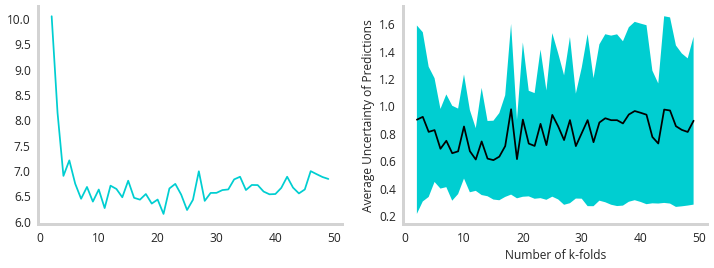

In [23]:
fig,ax=plt.subplots(1,2,figsize=(12,4))

ax[0].plot(k_values,MSE)
y=pd.DataFrame(uncertainty_dict).mean()

error=np.std(pd.DataFrame(uncertainty_dict))

ax[1].fill_between(k_values, y-error, y+error)
ax[1].plot(k_values,y,color='black')
ax[1].set_xlabel('Number of k-folds')
ax[1].set_ylabel('Average Uncertainty of Predictions')

In [ ]:
# Plotting K-fold ensemble on 

In [153]:
def train_models_lgb(X_dataset,y_dataset,params=None,n_splits=5):
    '''Function for training models 
    Inputs:
    X_dataset: Inputs of the training data (MxN)
    y_dataset: Outputs of the trainig data (1xN)
    params: the parameters of the LGBM model
    n_split: the number of splits to be used to creat int(n_splits) seperate models
    
    Returns:
    models: int(n_splits) number of independent models trained on the folds of the data
    '''
    if params is None:
        params = {
            'num_leaves': 50,
            'metric': ['l1', 'l2'],
            'verbose': -1,
            'learning_rate': 0.05,
            'lambda_l2': 1,
            'drop_rate': 0.1,
            'seed': 123,
            'objective':'regression'}
    
    kf = KFold(n_splits=n_splits)

    models=[]

    for train_index, test_index in kf.split(X_dataset):
        X_train, X_val, y_train, y_val = X_dataset[train_index,:], X_dataset[test_index,:], y_dataset[train_index], y_dataset[test_index]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_test = lgb.Dataset(X_val, y_val)

        gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=800,
                    valid_sets=[lgb_test],
                    early_stopping_rounds=20,
                    verbose_eval=0
                    )
        models.append(gbm)
    return models